In [ ]:
!unzip /content/drive/My\ Drive/Global_Wheat_Detection/global-wheat-detection.zip -d data

In [ ]:
!pip install -U git+https://github.com/albumentations-team/albumentations # '0.4.5'
!pip install torch=='1.4.0'
!pip install torchvision=='0.5.0'

In [ ]:
import pandas as pd
import numpy as np
import random
import cv2
import os
from glob import glob
import re
from copy import deepcopy
from time import time
from tqdm import tqdm_notebook


import numba
import ast
from numba import jit
from typing import List, Union, Tuple

from PIL import Image
from sklearn.model_selection import StratifiedKFold

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler, RandomSampler

from matplotlib import pyplot as plt
from IPython.display import clear_output


import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [ ]:
def set_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed(42)

In [ ]:
FOLD = 2
DATA_PATH = 'data'
PATH_TO_SAVE = '/content/drive/My Drive/Global_Wheat_Detection/frcnn_pseudo_labeling'
MODEL_NAME = f"FasterRCNN_aug_cutmix_pseudo_labeling_r1_fold_{FOLD}_v2.pth"
WEIGHTS_FILE = f"/content/drive/My Drive/Global_Wheat_Detection/frcnn_aug_cutmix_/FasterRCNN_aug_cutmix_fold_{FOLD}.pth"

In [ ]:
train_df = pd.read_csv(f'{DATA_PATH}/train.csv')

In [ ]:
DATA_ROOT_PATH = 'data/test'

class DatasetRetriever(Dataset):

    def __init__(self, image_ids, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{DATA_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']
        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [ ]:
def get_valid_transforms():
    return A.Compose([
            A.Resize(height=1024, width=1024, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)


In [ ]:
dataset = DatasetRetriever(image_ids=np.array([path.split('/')[-1][:-4] for path in glob(f'{DATA_ROOT_PATH}/*.jpg')]),
    transforms=get_valid_transforms()
)

def collate_fn(batch):
    return tuple(zip(*batch))

test_data_loader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    collate_fn=collate_fn)

In [ ]:
device = torch.device('cuda:0')
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)
num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load the trained weights
model.load_state_dict(torch.load(WEIGHTS_FILE))
model.eval();
model.to(device)

In [ ]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)

In [ ]:
detection_threshold = 0.5
results = []

testdf_psuedo = []
for images, image_ids in test_data_loader:

    images = list(image.to(device) for image in images)
    outputs = model(images)

    for i, image in enumerate(images):

        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()
        
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        
        for box in boxes:
            #print(box)
            result = {
                'image_id': 'ss_'+image_id,
                'width': 1024,
                'height': 1024,
                'source': 'ss',
                'x': box[0],
                'y': box[1],
                'w': box[2],
                'h': box[3]
            }
            testdf_psuedo.append(result)

In [ ]:
test_df_pseudo = pd.DataFrame(testdf_psuedo, columns=['image_id', 'width', 'height', 'source', 'x', 'y', 'w', 'h'])
test_df_pseudo.head()

,image_id,width,height,source,x,y,w,h
0,ss_cb8d261a3,1024,1024,ss,19,868,82,141
1,ss_cb8d261a3,1024,1024,ss,264,772,116,75
2,ss_cb8d261a3,1024,1024,ss,20,556,184,109
3,ss_cb8d261a3,1024,1024,ss,440,459,112,107
4,ss_cb8d261a3,1024,1024,ss,754,710,82,83


In [ ]:
train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['bbox'], inplace=True)
train_df['x'] = train_df['x'].astype(np.float)
train_df['y'] = train_df['y'].astype(np.float)
train_df['w'] = train_df['w'].astype(np.float)
train_df['h'] = train_df['h'].astype(np.float)

In [ ]:
train_df.head()

,image_id,width,height,source,x,y,w,h
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024,1024,usask_1,377.0,504.0,74.0,160.0
3,b6ab77fd7,1024,1024,usask_1,834.0,95.0,109.0,107.0
4,b6ab77fd7,1024,1024,usask_1,26.0,144.0,124.0,117.0


In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

df_folds = train_df[['image_id']].copy()
df_folds.loc[:, 'bbox_count'] = 1
df_folds = df_folds.groupby('image_id').count()
df_folds.loc[:, 'source'] = train_df[['image_id', 'source']].groupby('image_id').min()['source']
df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['source'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
)
df_folds.loc[:, 'fold'] = 0

for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [ ]:
class WheatDataset(Dataset):

    def __init__(self, marking, image_ids, transforms=None, test=False):
        super().__init__()

        self.image_ids = image_ids
        self.marking = marking
        self.transforms = transforms
        self.test = test

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        
        if self.test or random.random() > 0.5:
            image, boxes = self.load_image_and_boxes(index)
        else:
            image, boxes = self.load_cutmix_image_and_boxes(index)

        # there is only one class
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = area

        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })

                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    break

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        if image_id.startswith('ss_'):
            image = cv2.imread(f'{DATA_PATH}/test/{image_id[3:]}.jpg', cv2.IMREAD_COLOR)
        else:
            image = cv2.imread(f'{DATA_PATH}/train/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        records = self.marking[self.marking['image_id'] == image_id]
        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3] # coco -> pascal voc format
        return image, boxes

    def load_cutmix_image_and_boxes(self, index, imsize=1024):
        """ 
        This implementation of cutmix author:  https://github.com/ultralytics/yolov3 
        Refactoring and adaptation: https://www.kaggle.com/shonenkov
        """
        w, h = imsize, imsize
        s = imsize // 2
        xc, yc = [int(random.uniform(imsize * 0.25, imsize * 0.75)) for _ in range(2)]  # center x, y
        indexes = [index] + [random.randint(0, self.image_ids.shape[0] - 1) for _ in range(3)]

        result_image = np.full((imsize, imsize, 3), 1, dtype=np.float32)
        result_boxes = []

        for i, index in enumerate(indexes):
            image, boxes = self.load_image_and_boxes(index)
            if i == 0:
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)
            result_image[y1a:y2a, x1a:x2a] = image[y1b:y2b, x1b:x2b]
            padw = x1a - x1b
            padh = y1a - y1b
            boxes[:, 0] += padw
            boxes[:, 1] += padh
            boxes[:, 2] += padw
            boxes[:, 3] += padh

            result_boxes.append(boxes)

        result_boxes = np.concatenate(result_boxes, 0)
        np.clip(result_boxes[:, 0:], 0, 2 * s, out=result_boxes[:, 0:])
        result_boxes = result_boxes.astype(np.int32)
        result_boxes = result_boxes[np.where((result_boxes[:,2]-result_boxes[:,0])*(result_boxes[:,3]-result_boxes[:,1]) > 0)]

        return result_image, result_boxes

In [ ]:
def get_train_transforms():
    return A.Compose(
        [
            A.RandomSizedCrop(min_max_height=(800, 800), height=1024, width=1024, p=0.5),
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
            A.ToGray(p=0.01),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            # A.Resize(height=512, width=512, p=1.0),
            A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )
def get_valid_transforms():
    return A.Compose(
        [
            # A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )


In [ ]:
@jit(nopython=True)
def calculate_iou(gt, pr, form='pascal_voc') -> float:
    """Calculates the Intersection over Union.

    Args:
        gt: (np.ndarray[Union[int, float]]) coordinates of the ground-truth box
        pr: (np.ndarray[Union[int, float]]) coordinates of the prdected box
        form: (str) gt/pred coordinates format
            - pascal_voc: [xmin, ymin, xmax, ymax]
            - coco: [xmin, ymin, w, h]
    Returns:
        (float) Intersection over union (0.0 <= iou <= 1.0)
    """
    if form == 'coco':
        gt = gt.copy()
        pr = pr.copy()

        gt[2] = gt[0] + gt[2]
        gt[3] = gt[1] + gt[3]
        pr[2] = pr[0] + pr[2]
        pr[3] = pr[1] + pr[3]

    # Calculate overlap area
    dx = min(gt[2], pr[2]) - max(gt[0], pr[0]) + 1
    
    if dx < 0:
        return 0.0
    
    dy = min(gt[3], pr[3]) - max(gt[1], pr[1]) + 1
    if dy < 0:
        return 0.0

    overlap_area = dx * dy

    # Calculate union area
    union_area = (
            (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1) +
            (pr[2] - pr[0] + 1) * (pr[3] - pr[1] + 1) -
            overlap_area
    )

    return overlap_area / union_area

In [ ]:
@jit(nopython=True)
def find_best_match(gts, pred, pred_idx, threshold = 0.5, form = 'pascal_voc', ious=None) -> int:
    """Returns the index of the 'best match' between the
    ground-truth boxes and the prediction. The 'best match'
    is the highest IoU. (0.0 IoUs are ignored).

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        pred: (List[Union[int, float]]) Coordinates of the predicted box
        pred_idx: (int) Index of the current predicted box
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (int) Index of the best match GT box (-1 if no match above threshold)
    """
    best_match_iou = -np.inf
    best_match_idx = -1

    for gt_idx in range(len(gts)):
        
        if gts[gt_idx][0] < 0:
            # Already matched GT-box
            continue
        
        iou = -1 if ious is None else ious[gt_idx][pred_idx]
        if iou < 0:
            iou = calculate_iou(gts[gt_idx], pred, form=form)
            
            if ious is not None:
                ious[gt_idx][pred_idx] = iou

        if iou < threshold:
            continue

        if iou > best_match_iou:
            best_match_iou = iou
            best_match_idx = gt_idx

    return best_match_idx

@jit(nopython=True)
def calculate_precision(gts, preds, threshold = 0.5, form = 'coco', ious=None) -> float:
    """Calculates precision for GT - prediction pairs at one threshold.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (float) Precision
    """
    n = len(preds)
    tp = 0
    fp = 0
    
    # for pred_idx, pred in enumerate(preds_sorted):
    for pred_idx in range(n):

        best_match_gt_idx = find_best_match(gts, preds[pred_idx], pred_idx,
                                            threshold=threshold, form=form, ious=ious)

        if best_match_gt_idx >= 0:
            # True positive: The predicted box matches a gt box with an IoU above the threshold.
            tp += 1
            # Remove the matched GT box
            gts[best_match_gt_idx] = -1

        else:
            # No match
            # False positive: indicates a predicted box had no associated gt box.
            fp += 1

    # False negative: indicates a gt box had no associated predicted box.
    fn = (gts.sum(axis=1) > 0).sum()

    return tp / (tp + fp + fn)

@jit(nopython=True)
def calculate_image_precision(gts, preds, thresholds = (0.5, ), form = 'coco') -> float:
    """Calculates image precision.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        thresholds: (float) Different thresholds
        form: (str) Format of the coordinates

    Return:
        (float) Precision
    """
    n_threshold = len(thresholds)
    image_precision = 0.0
    
    ious = np.ones((len(gts), len(preds))) * -1
    # ious = None

    for threshold in thresholds:
        precision_at_threshold = calculate_precision(gts.copy(), preds, threshold=threshold,
                                                     form=form, ious=ious)
        image_precision += precision_at_threshold / n_threshold

    return image_precision

In [ ]:
train_df

,image_id,width,height,source,x,y,w,h
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024,1024,usask_1,377.0,504.0,74.0,160.0
3,b6ab77fd7,1024,1024,usask_1,834.0,95.0,109.0,107.0
4,b6ab77fd7,1024,1024,usask_1,26.0,144.0,124.0,117.0
...,...,...,...,...,...,...,...,...
147788,5e0747034,1024,1024,arvalis_2,64.0,619.0,84.0,95.0
147789,5e0747034,1024,1024,arvalis_2,292.0,549.0,107.0,82.0
147790,5e0747034,1024,1024,arvalis_2,134.0,228.0,141.0,71.0
147791,5e0747034,1024,1024,arvalis_2,430.0,13.0,184.0,79.0


In [ ]:
df_folds_pseudo = test_df_pseudo[['image_id']].copy()
df_folds_pseudo.loc[:, 'bbox_count'] = 1
df_folds_pseudo = df_folds_pseudo.groupby('image_id').count()
df_folds_pseudo.loc[:, 'source'] = test_df_pseudo[['image_id', 'source']].groupby('image_id').min()['source']
df_folds_pseudo.loc[:, 'stratify_group'] = np.char.add(
    df_folds_pseudo['source'].values.astype(str),
    df_folds_pseudo['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
)
df_folds_pseudo.loc[:, 'fold'] = -1

In [ ]:
frames = [train_df, test_df_pseudo]

train = pd.concat(frames)
train.head()


,image_id,width,height,source,x,y,w,h
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024,1024,usask_1,377.0,504.0,74.0,160.0
3,b6ab77fd7,1024,1024,usask_1,834.0,95.0,109.0,107.0
4,b6ab77fd7,1024,1024,usask_1,26.0,144.0,124.0,117.0


In [ ]:
train_dataset = WheatDataset(
    image_ids=pd.concat([df_folds[df_folds['fold'] != FOLD], df_folds_pseudo]).index.values,
    marking=train,
    transforms=get_train_transforms(),
    test=False,
)

validation_dataset = WheatDataset(
    image_ids=df_folds[df_folds['fold'] == FOLD].index.values,
    marking=train,
    transforms=get_valid_transforms(),
    test=True,
)

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=10,
        sampler=RandomSampler(train_dataset),
        pin_memory=False,
        drop_last=True,
        num_workers=4,
        collate_fn=collate_fn,
    )
val_loader = torch.utils.data.DataLoader(
        validation_dataset, 
        batch_size=6,
        num_workers=4,
        shuffle=False,
        sampler=SequentialSampler(validation_dataset),
        pin_memory=False,
        collate_fn=collate_fn,
    )

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


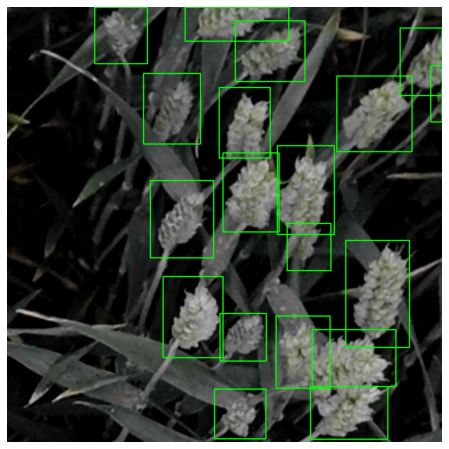

In [ ]:
image, target, image_id = train_dataset[2]
boxes = target['boxes'].cpu().numpy().astype(np.int32)

numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(numpy_image, (box[0], box[1]),
                  (box[2], box[3]), (0, 1, 0), 2)
    
ax.set_axis_off()
ax.imshow(numpy_image);

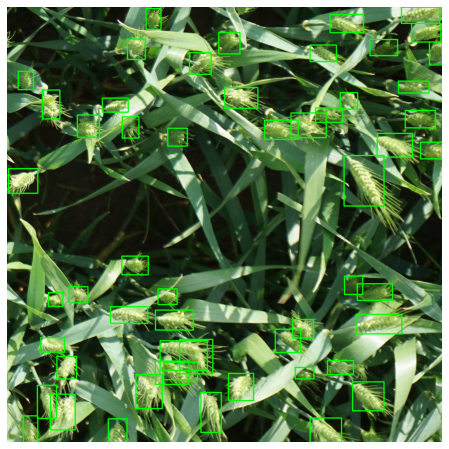

In [ ]:
image, target, image_id = next(iter(val_loader))
boxes = target[0]['boxes'].cpu().numpy().astype(np.int32)

numpy_image = image[0].permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(numpy_image, (box[0], box[1]),
                  (box[2], box[3]), (0, 1, 0), 2)
    
ax.set_axis_off()
ax.imshow(numpy_image);

In [ ]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.00001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

num_epochs = 6

In [ ]:
!nvidia-smi

Wed Jul  1 21:11:00 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    35W / 250W |  10623MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

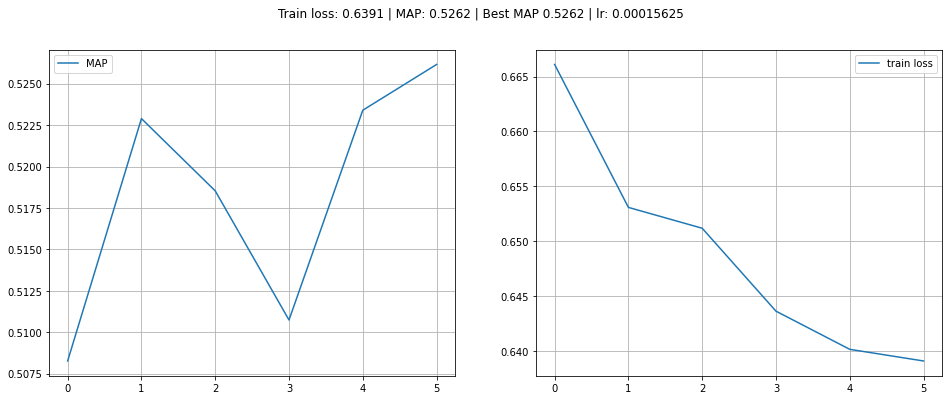

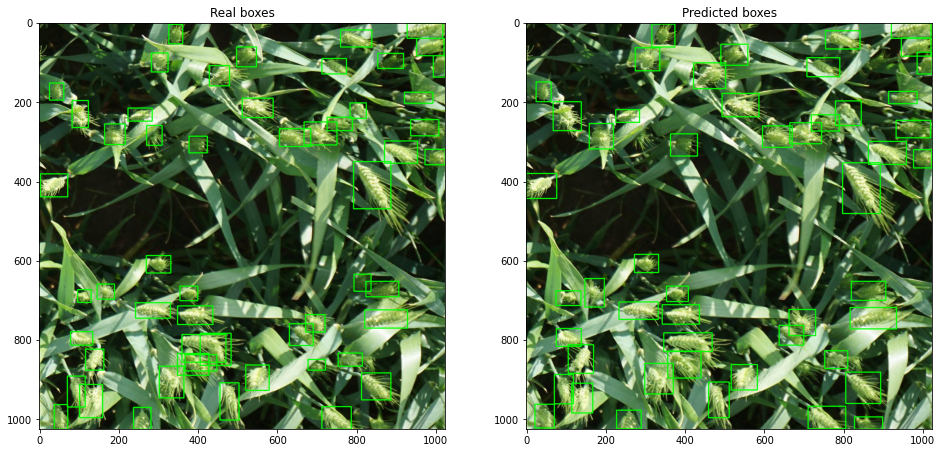

Training complete in 46m 50s


In [ ]:
model.to(device).float()
history = []
best_model_wts = deepcopy(model.state_dict())
best_map = 0.
since = time()

for epoch in range(num_epochs):
    model.train()
    avg_train_loss = 0
    with tqdm_notebook(desc=f"Epoch {epoch}/{num_epochs}", total=len(train_loader), position=0) as pbar:
        for images, targets, image_ids in train_loader:
            images = torch.stack(images)
            images = images.to(device)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)

            losses = sum(loss for loss in loss_dict.values())
            loss_value = losses.item()

            avg_train_loss += loss_value / len(train_loader)

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            pbar.update(1)
    model.eval()
    avg_val_loss = 0  # testing mode
    validation_image_precisions = []
    iou_thresholds = [x for x in np.arange(0.5, 0.76, 0.05)]

    with tqdm_notebook(desc=f"Validation", total=len(val_loader), position=0) as pbar_inner:
        for images, targets, image_ids in val_loader:
            with torch.no_grad():
                images = torch.stack(images)
                images = images.to(device)
                outputs = model(images)

            preds = [image['boxes'] for image in outputs]
            preds = torch.cat(preds).to('cpu').numpy()
            scores = [image['scores'] for image in outputs]
            scores = torch.cat(scores).to('cpu').numpy()

            gt_boxes = [image['boxes'] for image in targets]
            gt_boxes = torch.cat(gt_boxes).to('cpu').numpy()
            preds_sorted_idx = np.argsort(scores)[::-1]
            preds_sorted = preds[preds_sorted_idx]

            for idx, image in enumerate(images):
                image_precision = calculate_image_precision(preds_sorted,
                                                            gt_boxes,
                                                            thresholds=iou_thresholds,
                                                            form='pascal_voc')

                validation_image_precisions.append(image_precision)
            pbar_inner.update(1)

    mean_av_pres = np.mean(validation_image_precisions)
    history.append((avg_train_loss, mean_av_pres))

    # Save weights if MAP better than previous
    if mean_av_pres > best_map:
        best_map = mean_av_pres
        best_model_wts = deepcopy(model.state_dict())

    if lr_scheduler is not None:
        lr_scheduler.step()
    
    # Plot train loss and MAP
    clear_output(wait=True)
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    train_loss, mean_av_pres = zip(*history)
    ax[0].plot(mean_av_pres, label='MAP')
    ax[0].legend(loc='best')
    ax[0].grid()
    ax[1].plot(train_loss, label='train loss')
    ax[1].legend(loc='best')
    ax[1].grid()

    plt.suptitle(f"Train loss: {history[-1][0]:.4f} | MAP: {history[-1][1]:.4f} | Best MAP {best_map:.4f} | lr: {optimizer.param_groups[0]['lr']}")


    # Drawing predicted boxes anf ground trouth to check progress
    images, targets, image_ids = next(iter(val_loader))
    images = list(img.to(device) for img in images)
    targets = [{k: v.to('cpu') for k, v in t.items()} for t in targets]
    boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
    model.eval()
    with torch.no_grad():
        outputs = model(images)

    outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
    pred_boxes = outputs[0]['boxes'].cpu().detach().numpy().astype(np.int32)
    scores = outputs[0]['scores'].cpu().detach().numpy().astype(np.float32)

    numpy_image = images[0].permute(1,2,0).cpu().numpy()
    sample = deepcopy(numpy_image)
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))

    for box in boxes:
        cv2.rectangle(numpy_image, (box[0], box[1]),
                  (box[2], box[3]), (0, 1, 0), 2)

    for i, box in enumerate(pred_boxes):
        if scores[i] > 0.5:
            cv2.rectangle(sample, (box[0], box[1]),
                  (box[2], box[3]), (0, 1, 0), 2)

    ax[0].imshow(numpy_image);
    ax[0].set_title('Real boxes')

    ax[1].imshow(sample)
    ax[1].set_title('Predicted boxes')

    plt.show()


time_elapsed = time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

model.load_state_dict(best_model_wts)
torch.save(model.state_dict(), f"{PATH_TO_SAVE}/{MODEL_NAME}") 
with open(f"{PATH_TO_SAVE}/history_v2.txt", 'w') as f:
    for line in history:
        f.write(','.join([str(i) for i in line])+'\n')